In [ ]:
import os
from pyspark.sql import SparkSession

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../.env")

os.environ["PYSPARK_SUBMIT_ARGS"] = "--packages org.apache.hadoop:hadoop-aws:3.3.4,io.delta:delta-spark_2.12:3.3.0 pyspark-shell"

# Initialize Spark session with Delta Lake and MinIO support
spark = SparkSession.builder \
    .appName("DeltaLakeWithMinIO") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("delta.autoOptimize.optimizeWrite", "true") \
    .config("delta.autoOptimize.autoCompact", "true") \
    .config("spark.delta.logStore.class", "org.apache.spark.sql.delta.storage.S3SingleDriverLogStore") \
    .config("spark.hadoop.fs.s3a.endpoint", os.getenv("MINIO_ENDPOINT")) \
    .config("spark.hadoop.fs.s3a.access.key", os.getenv("MINIO_ACCESS_KEY")) \
    .config("spark.hadoop.fs.s3a.secret.key", os.getenv("MINIO_SECRET_KEY")) \
    .config('spark.hadoop.fs.s3a.attempts.maximum', "3") \
    .config('spark.hadoop.fs.s3a.connection.timeout', "10000") \
    .config('spark.hadoop.fs.s3a.connection.establish.timeout', "5000") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3n.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .getOrCreate()

print("Spark session configured with Delta Lake and MinIO!")

your 131072x1 screen size is bogus. expect trouble
25/01/26 11:01:16 WARN Utils: Your hostname, CPC-12806 resolves to a loopback address: 127.0.1.1; using 172.26.242.248 instead (on interface eth0)
25/01/26 11:01:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/arthur/streaming-pipeline/.venv/lib/python3.13/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/arthur/.ivy2/cache
The jars for the packages stored in: /home/arthur/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-93c9fbe6-99bc-4597-90c6-358e09668ff1;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found io.delta#delta-spark_2.12;3.3.0 in central
	found io.delta#delta-storage;3.3.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 297ms :: artifacts dl 11ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.12.262 from central in [default]
	io.delta#delta-spark_2.12;3.3.0 from central in [default]
	io.delta#delta-storage;3.3.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	org.apache.hado

Spark session configured with Delta Lake and MinIO!


In [2]:
spark.sql("SELECT COUNT(*) FROM delta.`s3a://lakehouse/delta/raw_control_power`;").show(5)

25/01/26 11:01:22 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
25/01/26 11:01:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+
|count(1)|
+--------+
|    2501|
+--------+



In [3]:
spark.sql("SELECT * FROM delta.`s3a://lakehouse/delta/raw_control_power`;").show(5)

+--------------------+-------------+---------+------+--------------------+-------------+--------------------+---------------+--------------+--------+---------+-----------+----------+------------+--------------+----------+--------------------+
|                 key|        topic|partition|offset|           timestamp|timestampType|   landing_timestamp|robot_action_id|apparent_power| current|frequency|phase_angle|     power|power_factor|reactive_power|   voltage|    source_timestamp|
+--------------------+-------------+---------+------+--------------------+-------------+--------------------+---------------+--------------+--------+---------+-----------+----------+------------+--------------+----------+--------------------+
|2025-01-25T20:53:...|control_power|       12|   176|2025-01-25 17:53:...|            0|2025-01-25 17:53:...|            4.0|    276.401062|1.409595|49.951218| 335.569427| 251.65654|    0.910476|   -114.298454|227.862411|2025-01-25 17:53:...|
|2025-01-25T20:53:...|contro

In [4]:
spark.sql("SELECT * FROM delta.`s3a://lakehouse/delta/raw_control_power`;")

DataFrame[key: string, topic: string, partition: int, offset: bigint, timestamp: timestamp, timestampType: int, landing_timestamp: timestamp, robot_action_id: string, apparent_power: double, current: double, frequency: double, phase_angle: double, power: double, power_factor: double, reactive_power: double, voltage: double, source_timestamp: timestamp]

In [5]:
# Calculate deltas and create a new temporary view
spark.sql("""
    SELECT 
        *,
        UNIX_TIMESTAMP(timestamp) - UNIX_TIMESTAMP(source_timestamp) AS delta_source_to_kafka,
        UNIX_TIMESTAMP(landing_timestamp) - UNIX_TIMESTAMP(timestamp) AS delta_kafka_to_landing
    FROM delta.`s3a://lakehouse/delta/raw_control_power`;
""").createOrReplaceTempView("kafka_deltas")

In [6]:
spark.sql("SELECT * FROM kafka_deltas;").show(5)

+--------------------+-------------+---------+------+--------------------+-------------+--------------------+---------------+--------------+--------+---------+-----------+----------+------------+--------------+----------+--------------------+---------------------+----------------------+
|                 key|        topic|partition|offset|           timestamp|timestampType|   landing_timestamp|robot_action_id|apparent_power| current|frequency|phase_angle|     power|power_factor|reactive_power|   voltage|    source_timestamp|delta_source_to_kafka|delta_kafka_to_landing|
+--------------------+-------------+---------+------+--------------------+-------------+--------------------+---------------+--------------+--------+---------+-----------+----------+------------+--------------+----------+--------------------+---------------------+----------------------+
|2025-01-25T20:53:...|control_power|       12|   176|2025-01-25 17:53:...|            0|2025-01-25 17:53:...|            4.0|    276.401

In [25]:
pandas_kafka_deltas = spark.sql("SELECT * FROM kafka_deltas;").toPandas()

In [33]:
pandas_kafka_deltas[pandas_kafka_deltas["timestamp"] == pandas_kafka_deltas["source_timestamp"]]

,key,topic,partition,offset,timestamp,timestampType,landing_timestamp,robot_action_id,apparent_power,current,frequency,phase_angle,power,power_factor,reactive_power,voltage,source_timestamp,delta_source_to_kafka,delta_kafka_to_landing


In [38]:
delta = pandas_kafka_deltas["timestamp"] - pandas_kafka_deltas["source_timestamp"]

Possivelmente aqui aparece um atraso entre relógios da minha máquina vs o servidor do kafka

Precision:

* Kafka timestamp is stored as milliseconds since the epoch (Unix time in milliseconds).
* It supports millisecond precision (yyyy-MM-dd HH:mm:ss.SSS).
* Kafka relies on the system clock of the producer (or the broker in the case of LogAppendTime).

In [39]:
delta.describe()

count                         2501
mean     0 days 00:00:00.000774009
std      0 days 00:00:00.000767378
min       -1 days +23:59:59.999777
25%         0 days 00:00:00.000310
50%         0 days 00:00:00.000632
75%         0 days 00:00:00.000990
max         0 days 00:00:00.012752
dtype: object

Types of Timestamps:

* CreateTime (timestampType=0): Provided by the producer, reflecting when the record was created.
* LogAppendTime (timestampType=1): Added by the Kafka broker when the message is appended to a partition log.

In [43]:
pandas_kafka_deltas["timestampType"].unique()

array([0], dtype=int32)

Timestamp is being provided by the producer.

---

**Comparing Kafka vs Python Timestamp Precision**

| **Aspect**           | **Kafka `timestamp`**           | **Python `datetime.now(timezone.utc).isoformat()`** |
|-----------------------|----------------------------------|----------------------------------------------------|
| **Precision**         | Milliseconds (`.SSS`)          | Microseconds (`.SSSSSS`)                          |
| **Format**            | `yyyy-MM-dd HH:mm:ss.SSS`      | `yyyy-MM-ddTHH:mm:ss.SSSSSS+00:00`                |
| **Timezone**          | UTC                            | UTC                                               |
| **Clock Dependency**  | Producer/broker system clock   | Host OS clock                                     |


O spark calculou o valor diferente, como converteu para UNIX parece a diferença em 1 segundo, porque?

* Spark's unix_timestamp() converts timestamps into seconds since the epoch, resulting in a loss of sub-second precision.
* Pandas Timestamp retains full precision down to nanoseconds.

In [41]:
pandas_kafka_deltas["delta_source_to_kafka"].describe()

count    2501.000000
mean        0.000400
std         0.019996
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: delta_source_to_kafka, dtype: float64

In [17]:
# Calculate bounds for 0.01% and 99.99% percentiles
bounds = {}
for delta_type in ["delta_source_to_kafka", "delta_kafka_to_landing"]:
    lower_bound = pandas_kafka_deltas[delta_type].quantile(0.0001)
    upper_bound = pandas_kafka_deltas[delta_type].quantile(0.9999)
    bounds[delta_type] = (lower_bound, upper_bound)
    print(f"{delta_type}: Lower Bound = {lower_bound}, Upper Bound = {upper_bound}")

# Filter the data
filtered_df = pandas_kafka_deltas[
    (pandas_kafka_deltas["delta_source_to_kafka"] >= bounds["delta_source_to_kafka"][0]) &
    (pandas_kafka_deltas["delta_source_to_kafka"] <= bounds["delta_source_to_kafka"][1]) &
    (pandas_kafka_deltas["delta_kafka_to_landing"] >= bounds["delta_kafka_to_landing"][0]) &
    (pandas_kafka_deltas["delta_kafka_to_landing"] <= bounds["delta_kafka_to_landing"][1])
]

delta_source_to_kafka: Lower Bound = 0.0, Upper Bound = 0.7499999999995453
delta_kafka_to_landing: Lower Bound = 0.0, Upper Bound = 35.49999999999909


In [22]:
filtered_df[["delta_source_to_kafka", "delta_kafka_to_landing"]].describe()

,delta_source_to_kafka,delta_kafka_to_landing
count,2499.0,2499.000000
mean,0.0,7.645858
std,0.0,6.352836
min,0.0,0.000000
25%,0.0,3.000000
50%,0.0,6.000000
75%,0.0,10.000000
max,0.0,34.000000


In [18]:
import pandas as pd

# Melt the DataFrame for FacetGrid
melted_df = pd.melt(
    filtered_df,
    value_vars=["delta_source_to_kafka", "delta_kafka_to_landing"],
    var_name="delta_type",  # Label for the type of delta
    value_name="time_delta"  # The time delta values
)


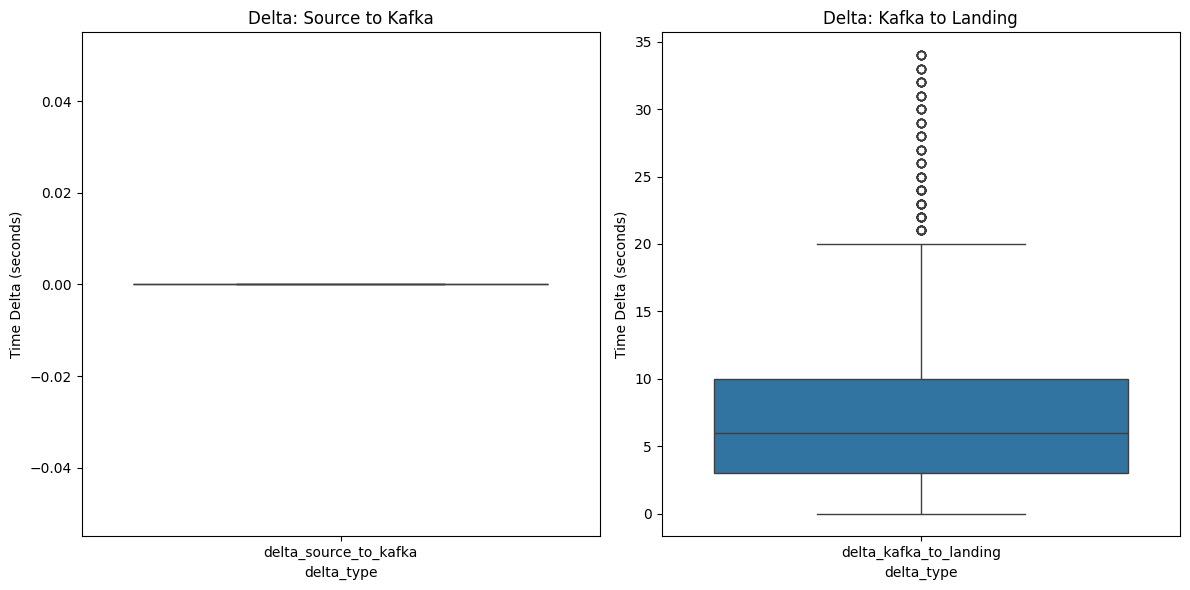

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Separate data for each delta type
source_to_kafka = melted_df[melted_df["delta_type"] == "delta_source_to_kafka"]
kafka_to_landing = melted_df[melted_df["delta_type"] == "delta_kafka_to_landing"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1]})

# Plot the first boxplot (delta_source_to_kafka)
sns.boxplot(
    ax=axes[0],
    data=source_to_kafka,
    x="delta_type",
    y="time_delta"
)
axes[0].set_title("Delta: Source to Kafka")
axes[0].set_ylabel("Time Delta (seconds)")
axes[0].set_ylim(0, )

# Plot the second boxplot (delta_kafka_to_landing)
sns.boxplot(
    ax=axes[1],
    data=kafka_to_landing,
    x="delta_type",
    y="time_delta"
)
axes[1].set_title("Delta: Kafka to Landing")
axes[1].set_ylabel("Time Delta (seconds)")

# Adjust spacing
plt.tight_layout()
plt.show()


In [27]:
# Calculate statistics using SQL
stats_query = spark.sql("""
    SELECT
        AVG(delta_source_to_kafka) AS avg_source_to_kafka,
        STDDEV(delta_source_to_kafka) AS stddev_source_to_kafka,
        MIN(delta_source_to_kafka) AS min_source_to_kafka,
        MAX(delta_source_to_kafka) AS max_source_to_kafka,
        PERCENTILE_APPROX(delta_source_to_kafka, 0.5) AS median_source_to_kafka,

        AVG(delta_kafka_to_landing) AS avg_kafka_to_landing,
        STDDEV(delta_kafka_to_landing) AS stddev_kafka_to_landing,
        MIN(delta_kafka_to_landing) AS min_kafka_to_landing,
        MAX(delta_kafka_to_landing) AS max_kafka_to_landing,
        PERCENTILE_APPROX(delta_kafka_to_landing, 0.5) AS median_kafka_to_landing
    FROM kafka_deltas;
""")

In [28]:
# Show the statistics
stats_query.show()

+--------------------+----------------------+-------------------+-------------------+----------------------+--------------------+-----------------------+--------------------+--------------------+-----------------------+
| avg_source_to_kafka|stddev_source_to_kafka|min_source_to_kafka|max_source_to_kafka|median_source_to_kafka|avg_kafka_to_landing|stddev_kafka_to_landing|min_kafka_to_landing|max_kafka_to_landing|median_kafka_to_landing|
+--------------------+----------------------+-------------------+-------------------+----------------------+--------------------+-----------------------+--------------------+--------------------+-----------------------+
|3.998400639744102...|  0.019996001199600138|                  0|                  1|                     0|   7.655737704918033|      6.375973342602189|                   0|                  36|                      6|
+--------------------+----------------------+-------------------+-------------------+----------------------+------------

In [20]:
spark.sql("DESCRIBE delta.`s3a://lakehouse/delta/raw_control_power`;").show()

+-----------------+---------+-------+
|         col_name|data_type|comment|
+-----------------+---------+-------+
|              key|   string|   NULL|
|            topic|   string|   NULL|
|        partition|      int|   NULL|
|           offset|   bigint|   NULL|
|        timestamp|timestamp|   NULL|
|    timestampType|      int|   NULL|
|landing_timestamp|timestamp|   NULL|
|  robot_action_id|   string|   NULL|
|   apparent_power|   double|   NULL|
|          current|   double|   NULL|
|        frequency|   double|   NULL|
|      phase_angle|   double|   NULL|
|            power|   double|   NULL|
|     power_factor|   double|   NULL|
|   reactive_power|   double|   NULL|
|          voltage|   double|   NULL|
| source_timestamp|timestamp|   NULL|
+-----------------+---------+-------+



In [21]:
spark.sql("DESCRIBE DETAIL delta.`s3a://lakehouse/delta/raw_control_power`;").show(truncate=False)

+------+------------------------------------+----+-----------+---------------------------------------+-----------------------+-------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+------------------------+
|format|id                                  |name|description|location                               |createdAt              |lastModified       |partitionColumns|clusteringColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|tableFeatures           |
+------+------------------------------------+----+-----------+---------------------------------------+-----------------------+-------------------+----------------+-----------------+--------+-----------+----------+----------------+----------------+------------------------+
|delta |6032d8f2-01c8-488b-ae06-4ab4151dc391|NULL|NULL       |s3a://lakehouse/delta/raw_control_power|2025-01-25 17:51:27.978|2025-01-25 17:50:16|[]              |[]               |

In [16]:
df = spark.read.format("delta").load("s3a://lakehouse/delta/processed_iot_data")
df.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- _change_type: string (nullable = true)
 |-- _commit_version: long (nullable = true)
 |-- _commit_timestamp: timestamp (nullable = true)



In [21]:
# Stream the changes using CDF
streaming_df = spark.readStream \
    .format("delta") \
    .option("readChangeFeed", "true") \
    .option("startingVersion", "latest") \
    .load("s3a://lakehouse/delta/processed_iot_data")

# Filter to keep only 'timestamp' and 'temperature' columns
filtered_streaming_df = streaming_df.select("timestamp", "temperature") \
    .withColumnRenamed("timestamp", "event_time") \
    .withColumnRenamed("temperature", "sensor_temp")

# Process and display the streaming changes
query = filtered_streaming_df.writeStream \
    .format("console") \
    .option("checkpointLocation", "s3a://lakehouse/delta/checkpoints/test") \
    .start()

# Monitor the query progress
import time

while query.isActive:
    print(query.lastProgress)  # Shows the latest progress info
    time.sleep(5)  # Updates every 5 seconds

25/01/16 14:01:32 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


None
{'id': 'bac56a91-3658-421d-8974-17c72e58191b', 'runId': 'e7a365e3-2592-4fee-a7a6-807934ad2aa2', 'name': None, 'timestamp': '2025-01-16T17:01:32.991Z', 'batchId': 0, 'numInputRows': 0, 'inputRowsPerSecond': 0.0, 'processedRowsPerSecond': 0.0, 'durationMs': {'latestOffset': 352, 'triggerExecution': 590}, 'stateOperators': [], 'sources': [{'description': 'DeltaSource[s3a://lakehouse/delta/processed_iot_data]', 'startOffset': None, 'endOffset': None, 'latestOffset': None, 'numInputRows': 0, 'inputRowsPerSecond': 0.0, 'processedRowsPerSecond': 0.0}], 'sink': {'description': 'org.apache.spark.sql.execution.streaming.ConsoleTable$@44ebbfa0', 'numOutputRows': -1}}
{'id': 'bac56a91-3658-421d-8974-17c72e58191b', 'runId': 'e7a365e3-2592-4fee-a7a6-807934ad2aa2', 'name': None, 'timestamp': '2025-01-16T17:01:32.991Z', 'batchId': 0, 'numInputRows': 0, 'inputRowsPerSecond': 0.0, 'processedRowsPerSecond': 0.0, 'durationMs': {'latestOffset': 352, 'triggerExecution': 590}, 'stateOperators': [], 'sou

KeyboardInterrupt: 